### Introduction to Preprocessing: DecayTime-Weighting Experiments

## Preprocessing 

This version we are looking to find good (if not optimal) puzzle day-specific decay function paramters for a feature capturing GMS recent performance prior to a given solve. This means looking for a combo of number of past matches to include (5,8,9,10,11,15,20,25 evaluated) and the decay weights (ranging from no decay weighting to a steep curve) for each of those past matches that yields the best univariate prediction of solve time (RMSE trainig error in minutes) over the 15x15 puzzle set. 

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_for_modeling.csv')
df.head()

,P_Date,P_Date_str,DOW,GMST(m),GMS_pds_l10_dw,GMS_pds_l25_dw,GMS_pds_l10_stdev,GMS_pds_l25_stdev,GMST_Diff%_from_GMS_pds_l10_dw,GMS_per_constr_avg_past_diff_from_RPB,...,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay,overall_day_mean_GMST(m)
0,2024-02-03,2024-02-03,Saturday,22.583333,19.944848,21.907538,5.103116,4.545437,12.41,NaN,...,0,0,0,0,0,0,0,0,7.0,26.541479
1,2024-02-02,2024-02-02,Friday,18.783333,17.210909,17.334205,3.480521,2.455251,8.74,NaN,...,0,0,0,0,0,0,0,0,6.0,21.449373
2,2024-02-01,2024-02-01,Thursday,19.700000,15.780606,16.550718,2.244750,4.131868,22.09,7.74,...,0,0,0,0,0,0,0,0,5.0,20.709774
3,2024-01-31,2024-01-31,Wednesday,10.783333,11.621515,12.138103,2.338474,2.691352,-7.48,NaN,...,17,0,0,0,0,0,0,0,5.0,13.259712
4,2024-01-30,2024-01-30,Tuesday,7.383333,7.765758,7.783641,1.156256,1.306190,-5.05,-8.32,...,0,0,0,0,0,0,0,0,2.0,9.720614


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   P_Date                                 1596 non-null   object 
 1   P_Date_str                             1596 non-null   object 
 2   DOW                                    1596 non-null   object 
 3   GMST(m)                                1596 non-null   float64
 4   GMS_pds_l10_dw                         1595 non-null   float64
 5   GMS_pds_l25_dw                         1595 non-null   float64
 6   GMS_pds_l10_stdev                      1595 non-null   float64
 7   GMS_pds_l25_stdev                      1595 non-null   float64
 8   GMST_Diff%_from_GMS_pds_l10_dw         1595 non-null   float64
 9   GMS_per_constr_avg_past_diff_from_RPB  1071 non-null   float64
 10  GMS_per_constr_past_diff_from_RPB_ct   1596 non-null   float64
 11  GMS_

### Create Feature Variants for Testing

### Filter Data

In [287]:
# strip down df to just the columns we need to evaluate decay function and number of day-specific puzzles to include
df1 = df[['DOW', 'P_Date', 'GMST(m)']]

In [288]:
# #IS_pds_l5_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 5 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

# df1 = df1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# w = [1,1,1,1,1] #weight assigned to puzzle
# #w = [5,4,3,2,1] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,5,5,5,5] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,5,3,3,1] #weight assigned to puzzle
# #w = [10,8,6,6,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [20,18,14,8,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
# #w = [1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

# df1["IS_pds_l5_dw_1"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)*w[0]
# df1["IS_pds_l5_dw_2"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)*w[1]
# df1["IS_pds_l5_dw_3"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)*w[2]
# df1["IS_pds_l5_dw_4"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)*w[3]
# df1["IS_pds_l5_dw_5"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)*w[4]

# df1["IS_pds_l5_dw_1_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1))*w[0]
# df1["IS_pds_l5_dw_2_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2))*w[1]
# df1["IS_pds_l5_dw_3_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3))*w[2]
# df1["IS_pds_l5_dw_4_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4))*w[3]
# df1["IS_pds_l5_dw_5_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5))*w[4]

# df1["IS_pds_l5_ws"] = df1[["IS_pds_l5_dw_1", "IS_pds_l5_dw_2", "IS_pds_l5_dw_3", "IS_pds_l5_dw_4", "IS_pds_l5_dw_5"]].sum(axis=1)
# df1["IS_pds_l5_ws_ct"] = df1[["IS_pds_l5_dw_1_ct", "IS_pds_l5_dw_2_ct", "IS_pds_l5_dw_3_ct", "IS_pds_l5_dw_4_ct", "IS_pds_l5_dw_5_ct"]].sum(axis=1)
# df1["IS_pds_l5_dw"] = df1["IS_pds_l5_ws"]/df1["IS_pds_l5_ws_ct"]

# # Deleting transient columns
# df1 = df1.drop(["IS_pds_l5_dw_1", "IS_pds_l5_dw_2", "IS_pds_l5_dw_3", "IS_pds_l5_dw_4", "IS_pds_l5_dw_5", "IS_pds_l5_ws", "IS_pds_l5_dw_1_ct", "IS_pds_l5_dw_2_ct", "IS_pds_l5_dw_3_ct", "IS_pds_l5_dw_4_ct", "IS_pds_l5_dw_5_ct", "IS_pds_l5_ws_ct"], axis = 1)

In [289]:
# #IS_pds_l8_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 10 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

# df1 = df1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# #w = [8,7,6,5,4,3,2,1] #weight assigned to puzzle
# w = [1,1,1,1,1,1,1,1] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,5,5,5,5] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,5,3,3,1] #weight assigned to puzzle
# #w = [10,8,6,6,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [20,18,14,8,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# df1["IS_pds_l8_dw_1"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)*w[0]
# df1["IS_pds_l8_dw_2"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)*w[1]
# df1["IS_pds_l8_dw_3"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)*w[2]
# df1["IS_pds_l8_dw_4"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)*w[3]
# df1["IS_pds_l8_dw_5"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)*w[4]
# df1["IS_pds_l8_dw_6"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)*w[5]
# df1["IS_pds_l8_dw_7"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)*w[6]
# df1["IS_pds_l8_dw_8"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)*w[7]

# df1["IS_pds_l8_dw_1_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1))*w[0]
# df1["IS_pds_l8_dw_2_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2))*w[1]
# df1["IS_pds_l8_dw_3_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3))*w[2]
# df1["IS_pds_l8_dw_4_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4))*w[3]
# df1["IS_pds_l8_dw_5_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5))*w[4]
# df1["IS_pds_l8_dw_6_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6))*w[5]
# df1["IS_pds_l8_dw_7_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7))*w[6]
# df1["IS_pds_l8_dw_8_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8))*w[7]

# df1["IS_pds_l8_ws"] = df1[["IS_pds_l8_dw_1", "IS_pds_l8_dw_2", "IS_pds_l8_dw_3", "IS_pds_l8_dw_4", "IS_pds_l8_dw_5", "IS_pds_l8_dw_6", "IS_pds_l8_dw_7", "IS_pds_l8_dw_8"]].sum(axis=1)
# df1["IS_pds_l8_ws_ct"] = df1[["IS_pds_l8_dw_1_ct", "IS_pds_l8_dw_2_ct", "IS_pds_l8_dw_3_ct", "IS_pds_l8_dw_4_ct", "IS_pds_l8_dw_5_ct", "IS_pds_l8_dw_6_ct", "IS_pds_l8_dw_7_ct", "IS_pds_l8_dw_8_ct"]].sum(axis=1)
# df1["IS_pds_l8_dw"] = df1["IS_pds_l8_ws"]/df1["IS_pds_l8_ws_ct"]

# # Deleting transient columns
# df1 = df1.drop(["IS_pds_l8_dw_1", "IS_pds_l8_dw_2", "IS_pds_l8_dw_3", "IS_pds_l8_dw_4", "IS_pds_l8_dw_5", "IS_pds_l8_dw_6", "IS_pds_l8_dw_7", "IS_pds_l8_dw_8", "IS_pds_l8_ws", "IS_pds_l8_dw_1_ct", "IS_pds_l8_dw_2_ct", "IS_pds_l8_dw_3_ct", "IS_pds_l8_dw_4_ct", "IS_pds_l8_dw_5_ct", "IS_pds_l8_dw_6_ct", "IS_pds_l8_dw_7_ct", "IS_pds_l8_dw_8_ct", "IS_pds_l8_ws_ct"], axis = 1)

In [290]:
# #IS_pds_l9_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 10 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

# df1 = df1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# #w = [9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
# w = [1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

# df1["IS_pds_l9_dw_1"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)*w[0]
# df1["IS_pds_l9_dw_2"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)*w[1]
# df1["IS_pds_l9_dw_3"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)*w[2]
# df1["IS_pds_l9_dw_4"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)*w[3]
# df1["IS_pds_l9_dw_5"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)*w[4]
# df1["IS_pds_l9_dw_6"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)*w[5]
# df1["IS_pds_l9_dw_7"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)*w[6]
# df1["IS_pds_l9_dw_8"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)*w[7]
# df1["IS_pds_l9_dw_9"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)*w[8]


# df1["IS_pds_l9_dw_1_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1))*w[0]
# df1["IS_pds_l9_dw_2_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2))*w[1]
# df1["IS_pds_l9_dw_3_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3))*w[2]
# df1["IS_pds_l9_dw_4_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4))*w[3]
# df1["IS_pds_l9_dw_5_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5))*w[4]
# df1["IS_pds_l9_dw_6_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6))*w[5]
# df1["IS_pds_l9_dw_7_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7))*w[6]
# df1["IS_pds_l9_dw_8_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8))*w[7]
# df1["IS_pds_l9_dw_9_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9))*w[8]


# df1["IS_pds_l9_ws"] = df1[["IS_pds_l9_dw_1", "IS_pds_l9_dw_2", "IS_pds_l9_dw_3", "IS_pds_l9_dw_4", "IS_pds_l9_dw_5", "IS_pds_l9_dw_6", "IS_pds_l9_dw_7", "IS_pds_l9_dw_8", "IS_pds_l9_dw_9"]].sum(axis=1)
# df1["IS_pds_l9_ws_ct"] = df1[["IS_pds_l9_dw_1_ct", "IS_pds_l9_dw_2_ct", "IS_pds_l9_dw_3_ct", "IS_pds_l9_dw_4_ct", "IS_pds_l9_dw_5_ct", "IS_pds_l9_dw_6_ct", "IS_pds_l9_dw_7_ct", "IS_pds_l9_dw_8_ct", "IS_pds_l9_dw_9_ct"]].sum(axis=1)
# df1["IS_pds_l9_dw"] = df1["IS_pds_l9_ws"]/df1["IS_pds_l9_ws_ct"]

# # Deleting transient columns
# df1 = df1.drop(["IS_pds_l9_dw_1", "IS_pds_l9_dw_2", "IS_pds_l9_dw_3", "IS_pds_l9_dw_4", "IS_pds_l9_dw_5", "IS_pds_l9_dw_6", "IS_pds_l9_dw_7", "IS_pds_l9_dw_8", "IS_pds_l9_dw_9", "IS_pds_l9_ws", "IS_pds_l9_dw_1_ct", "IS_pds_l9_dw_2_ct", "IS_pds_l9_dw_3_ct", "IS_pds_l9_dw_4_ct", "IS_pds_l9_dw_5_ct", "IS_pds_l9_dw_6_ct", "IS_pds_l9_dw_7_ct", "IS_pds_l9_dw_8_ct", "IS_pds_l9_dw_9_ct", "IS_pds_l9_ws_ct"], axis = 1)

In [291]:
#GMS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for GMS over the previous 10 puzzles relative to a given puzzle
# Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

df1 = df1.sort_values(by=['DOW', 'P_Date'], ascending = False)

#w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
w = [1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

df1["GMS_pds_l10_dw_1"] = df1.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df1["GMS_pds_l10_dw_2"] = df1.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df1["GMS_pds_l10_dw_3"] = df1.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df1["GMS_pds_l10_dw_4"] = df1.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df1["GMS_pds_l10_dw_5"] = df1.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df1["GMS_pds_l10_dw_6"] = df1.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df1["GMS_pds_l10_dw_7"] = df1.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df1["GMS_pds_l10_dw_8"] = df1.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df1["GMS_pds_l10_dw_9"] = df1.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df1["GMS_pds_l10_dw_10"] = df1.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

df1["GMS_pds_l10_dw_1_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-1)/df1.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df1["GMS_pds_l10_dw_2_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-2)/df1.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df1["GMS_pds_l10_dw_3_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-3)/df1.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df1["GMS_pds_l10_dw_4_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-4)/df1.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df1["GMS_pds_l10_dw_5_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-5)/df1.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df1["GMS_pds_l10_dw_6_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-6)/df1.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df1["GMS_pds_l10_dw_7_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-7)/df1.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df1["GMS_pds_l10_dw_8_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-8)/df1.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df1["GMS_pds_l10_dw_9_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-9)/df1.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df1["GMS_pds_l10_dw_10_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-10)/df1.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

df1["GMS_pds_l10_ws"] = df1[["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10"]].sum(axis=1)
df1["GMS_pds_l10_ws_ct"] = df1[["GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct"]].sum(axis=1)
df1["GMS_pds_l10_dw"] = df1["GMS_pds_l10_ws"]/df1["GMS_pds_l10_ws_ct"]

# Deleting transient columns
df1 = df1.drop(["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10", "GMS_pds_l10_ws", "GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct", "GMS_pds_l10_ws_ct"], axis = 1)

In [292]:
# #IS_pds_l11_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 11 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

# df1 = df1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# #w = [11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
# w = [1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

# df1["IS_pds_l11_dw_1"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)*w[0]
# df1["IS_pds_l11_dw_2"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)*w[1]
# df1["IS_pds_l11_dw_3"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)*w[2]
# df1["IS_pds_l11_dw_4"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)*w[3]
# df1["IS_pds_l11_dw_5"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)*w[4]
# df1["IS_pds_l11_dw_6"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)*w[5]
# df1["IS_pds_l11_dw_7"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)*w[6]
# df1["IS_pds_l11_dw_8"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)*w[7]
# df1["IS_pds_l11_dw_9"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)*w[8]
# df1["IS_pds_l11_dw_10"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10)*w[9]
# df1["IS_pds_l11_dw_11"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11)*w[10]

# df1["IS_pds_l11_dw_1_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1))*w[0]
# df1["IS_pds_l11_dw_2_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2))*w[1]
# df1["IS_pds_l11_dw_3_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3))*w[2]
# df1["IS_pds_l11_dw_4_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4))*w[3]
# df1["IS_pds_l11_dw_5_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5))*w[4]
# df1["IS_pds_l11_dw_6_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6))*w[5]
# df1["IS_pds_l11_dw_7_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7))*w[6]
# df1["IS_pds_l11_dw_8_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8))*w[7]
# df1["IS_pds_l11_dw_9_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9))*w[8]
# df1["IS_pds_l11_dw_10_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10))*w[9]
# df1["IS_pds_l11_dw_11_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11))*w[10]

# df1["IS_pds_l11_ws"] = df1[["IS_pds_l11_dw_1", "IS_pds_l11_dw_2", "IS_pds_l11_dw_3", "IS_pds_l11_dw_4", "IS_pds_l11_dw_5", "IS_pds_l11_dw_6", "IS_pds_l11_dw_7", "IS_pds_l11_dw_8", "IS_pds_l11_dw_9", "IS_pds_l11_dw_10", "IS_pds_l11_dw_11"]].sum(axis=1)
# df1["IS_pds_l11_ws_ct"] = df1[["IS_pds_l11_dw_1_ct", "IS_pds_l11_dw_2_ct", "IS_pds_l11_dw_3_ct", "IS_pds_l11_dw_4_ct", "IS_pds_l11_dw_5_ct", "IS_pds_l11_dw_6_ct", "IS_pds_l11_dw_7_ct", "IS_pds_l11_dw_8_ct", "IS_pds_l11_dw_9_ct", "IS_pds_l11_dw_10_ct", "IS_pds_l11_dw_11_ct"]].sum(axis=1)
# df1["IS_pds_l11_dw"] = df1["IS_pds_l11_ws"]/df1["IS_pds_l11_ws_ct"]

# # Deleting transient columns
# df1 = df1.drop(["IS_pds_l11_dw_1", "IS_pds_l11_dw_2", "IS_pds_l11_dw_3", "IS_pds_l11_dw_4", "IS_pds_l11_dw_5", "IS_pds_l11_dw_6", "IS_pds_l11_dw_7", "IS_pds_l11_dw_8", "IS_pds_l11_dw_9", "IS_pds_l11_dw_10", "IS_pds_l11_dw_11", "IS_pds_l11_ws", "IS_pds_l11_dw_1_ct", "IS_pds_l11_dw_2_ct", "IS_pds_l11_dw_3_ct", "IS_pds_l11_dw_4_ct", "IS_pds_l11_dw_5_ct", "IS_pds_l11_dw_6_ct", "IS_pds_l11_dw_7_ct", "IS_pds_l11_dw_8_ct", "IS_pds_l11_dw_9_ct", "IS_pds_l11_dw_10_ct","IS_pds_l11_dw_11_ct", "IS_pds_l11_ws_ct"], axis = 1)

In [293]:
# #IS_pds_l12_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 12 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

# df1 = df1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# #w = [12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
# w = [1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,5,5,5,5] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,5,3,3,1] #weight assigned to puzzle
# #w = [10,8,6,6,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [20,18,14,8,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# df1["IS_pds_l12_dw_1"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)*w[0]
# df1["IS_pds_l12_dw_2"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)*w[1]
# df1["IS_pds_l12_dw_3"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)*w[2]
# df1["IS_pds_l12_dw_4"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)*w[3]
# df1["IS_pds_l12_dw_5"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)*w[4]
# df1["IS_pds_l12_dw_6"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)*w[5]
# df1["IS_pds_l12_dw_7"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)*w[6]
# df1["IS_pds_l12_dw_8"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)*w[7]
# df1["IS_pds_l12_dw_9"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)*w[8]
# df1["IS_pds_l12_dw_10"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10)*w[9]
# df1["IS_pds_l12_dw_11"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11)*w[10]
# df1["IS_pds_l12_dw_12"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-12)*w[11]

# df1["IS_pds_l12_dw_1_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1))*w[0]
# df1["IS_pds_l12_dw_2_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2))*w[1]
# df1["IS_pds_l12_dw_3_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3))*w[2]
# df1["IS_pds_l12_dw_4_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4))*w[3]
# df1["IS_pds_l12_dw_5_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5))*w[4]
# df1["IS_pds_l12_dw_6_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6))*w[5]
# df1["IS_pds_l12_dw_7_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7))*w[6]
# df1["IS_pds_l12_dw_8_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8))*w[7]
# df1["IS_pds_l12_dw_9_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9))*w[8]
# df1["IS_pds_l12_dw_10_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10))*w[9]
# df1["IS_pds_l12_dw_11_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11))*w[10]
# df1["IS_pds_l12_dw_12_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-12)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-12))*w[11]

# df1["IS_pds_l12_ws"] = df1[["IS_pds_l12_dw_1", "IS_pds_l12_dw_2", "IS_pds_l12_dw_3", "IS_pds_l12_dw_4", "IS_pds_l12_dw_5", "IS_pds_l12_dw_6", "IS_pds_l12_dw_7", "IS_pds_l12_dw_8", "IS_pds_l12_dw_9", "IS_pds_l12_dw_10","IS_pds_l12_dw_11", "IS_pds_l12_dw_12"]].sum(axis=1)
# df1["IS_pds_l12_ws_ct"] = df1[["IS_pds_l12_dw_1_ct", "IS_pds_l12_dw_2_ct", "IS_pds_l12_dw_3_ct", "IS_pds_l12_dw_4_ct", "IS_pds_l12_dw_5_ct", "IS_pds_l12_dw_6_ct", "IS_pds_l12_dw_7_ct", "IS_pds_l12_dw_8_ct", "IS_pds_l12_dw_9_ct", "IS_pds_l12_dw_10_ct", "IS_pds_l12_dw_11_ct", "IS_pds_l12_dw_12_ct"]].sum(axis=1)
# df1["IS_pds_l12_dw"] = df1["IS_pds_l12_ws"]/df1["IS_pds_l12_ws_ct"]

# # Deleting transient columns
# df1 = df1.drop(["IS_pds_l12_dw_1", "IS_pds_l12_dw_2", "IS_pds_l12_dw_3", "IS_pds_l12_dw_4", "IS_pds_l12_dw_5", "IS_pds_l12_dw_6", "IS_pds_l12_dw_7", "IS_pds_l12_dw_8", "IS_pds_l12_dw_9", "IS_pds_l12_dw_10", "IS_pds_l12_dw_11", "IS_pds_l12_dw_12", "IS_pds_l12_ws", "IS_pds_l12_dw_1_ct", "IS_pds_l12_dw_2_ct", "IS_pds_l12_dw_3_ct", "IS_pds_l12_dw_4_ct", "IS_pds_l12_dw_5_ct", "IS_pds_l12_dw_6_ct", "IS_pds_l12_dw_7_ct", "IS_pds_l12_dw_8_ct", "IS_pds_l12_dw_9_ct", "IS_pds_l12_dw_10_ct", "IS_pds_l12_dw_11_ct", "IS_pds_l12_dw_12_ct", "IS_pds_l12_ws_ct"], axis = 1)

In [294]:
# #IS_pds_l15_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 15 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

# df1 = df1.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# #w = [15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
# w = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle
# #w = [20,18,14,8,4,4,2,2,1,1] #weight assigned to puzzle
# #w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
# #w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# df1["IS_pds_l15_dw_1"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)*w[0]
# df1["IS_pds_l15_dw_2"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)*w[1]
# df1["IS_pds_l15_dw_3"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)*w[2]
# df1["IS_pds_l15_dw_4"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)*w[3]
# df1["IS_pds_l15_dw_5"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)*w[4]
# df1["IS_pds_l15_dw_6"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)*w[5]
# df1["IS_pds_l15_dw_7"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)*w[6]
# df1["IS_pds_l15_dw_8"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)*w[7]
# df1["IS_pds_l15_dw_9"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)*w[8]
# df1["IS_pds_l15_dw_10"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10)*w[9]
# df1["IS_pds_l15_dw_11"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11)*w[10]
# df1["IS_pds_l15_dw_12"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-12)*w[11]
# df1["IS_pds_l15_dw_13"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-13)*w[12]
# df1["IS_pds_l15_dw_14"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-14)*w[13]
# df1["IS_pds_l15_dw_15"] = df1.groupby(['DOW'])['IS1_ST(m)'].shift(-15)*w[14]

# df1["IS_pds_l15_dw_1_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-1))*w[0]
# df1["IS_pds_l15_dw_2_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-2))*w[1]
# df1["IS_pds_l15_dw_3_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-3))*w[2]
# df1["IS_pds_l15_dw_4_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-4))*w[3]
# df1["IS_pds_l15_dw_5_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-5))*w[4]
# df1["IS_pds_l15_dw_6_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-6))*w[5]
# df1["IS_pds_l15_dw_7_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-7))*w[6]
# df1["IS_pds_l15_dw_8_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-8))*w[7]
# df1["IS_pds_l15_dw_9_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-9))*w[8]
# df1["IS_pds_l15_dw_10_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-10))*w[9]
# df1["IS_pds_l15_dw_11_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-11))*w[10]
# df1["IS_pds_l15_dw_12_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-12)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-12))*w[11]
# df1["IS_pds_l15_dw_13_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-13)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-13))*w[12]
# df1["IS_pds_l15_dw_14_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-14)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-14))*w[13]
# df1["IS_pds_l15_dw_15_ct"] = (df1.groupby(['DOW'])['IS1_ST(m)'].shift(-15)/df1.groupby(['DOW'])['IS1_ST(m)'].shift(-15))*w[14]

# df1["IS_pds_l15_ws"] = df1[["IS_pds_l15_dw_1", "IS_pds_l15_dw_2", "IS_pds_l15_dw_3", "IS_pds_l15_dw_4", "IS_pds_l15_dw_5", "IS_pds_l15_dw_6", "IS_pds_l15_dw_7", "IS_pds_l15_dw_8", "IS_pds_l15_dw_9", "IS_pds_l15_dw_10", "IS_pds_l15_dw_11", "IS_pds_l15_dw_12", "IS_pds_l15_dw_13", "IS_pds_l15_dw_14", "IS_pds_l15_dw_15"]].sum(axis=1)
# df1["IS_pds_l15_ws_ct"] = df1[["IS_pds_l15_dw_1_ct", "IS_pds_l15_dw_2_ct", "IS_pds_l15_dw_3_ct", "IS_pds_l15_dw_4_ct", "IS_pds_l15_dw_5_ct", "IS_pds_l15_dw_6_ct", "IS_pds_l15_dw_7_ct", "IS_pds_l15_dw_8_ct", "IS_pds_l15_dw_9_ct", "IS_pds_l15_dw_10_ct", "IS_pds_l15_dw_11_ct", "IS_pds_l15_dw_12_ct", "IS_pds_l15_dw_13_ct", "IS_pds_l15_dw_14_ct", "IS_pds_l15_dw_15_ct"]].sum(axis=1)
# df1["IS_pds_l15_dw"] = df1["IS_pds_l15_ws"]/df1["IS_pds_l15_ws_ct"]

# # Deleting transient columns
# df1 = df1.drop(["IS_pds_l15_dw_1", "IS_pds_l15_dw_2", "IS_pds_l15_dw_3", "IS_pds_l15_dw_4", "IS_pds_l15_dw_5", "IS_pds_l15_dw_6", "IS_pds_l15_dw_7", "IS_pds_l15_dw_8", "IS_pds_l15_dw_9", "IS_pds_l15_dw_10", "IS_pds_l15_dw_11", "IS_pds_l15_dw_12", "IS_pds_l15_dw_13", "IS_pds_l15_dw_14", "IS_pds_l15_dw_15", "IS_pds_l15_dw_1_ct", "IS_pds_l15_dw_2_ct", "IS_pds_l15_dw_3_ct", "IS_pds_l15_dw_4_ct", "IS_pds_l15_dw_5_ct", "IS_pds_l15_dw_6_ct", "IS_pds_l15_dw_7_ct", "IS_pds_l15_dw_8_ct", "IS_pds_l15_dw_9_ct", "IS_pds_l15_dw_10_ct", "IS_pds_l15_dw_11_ct", "IS_pds_l15_dw_12_ct", "IS_pds_l15_dw_13_ct", "IS_pds_l15_dw_14_ct", "IS_pds_l15_dw_15_ct", "IS_pds_l15_ws", "IS_pds_l15_ws_ct"], axis = 1)

In [333]:
# #GMS_pds_l20_dw
# #Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 20 puzzles relative to a given puzzle
# # Note that the sort is by completion date for IS1, as completion date was avaiable 
# # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

df1 = df1.sort_values(by=['DOW', 'P_Date'], ascending = False)

#w = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
w = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

df1["GMS_pds_l20_dw_1"] = df1.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df1["GMS_pds_l20_dw_2"] = df1.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df1["GMS_pds_l20_dw_3"] = df1.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df1["GMS_pds_l20_dw_4"] = df1.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df1["GMS_pds_l20_dw_5"] = df1.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df1["GMS_pds_l20_dw_6"] = df1.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df1["GMS_pds_l20_dw_7"] = df1.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df1["GMS_pds_l20_dw_8"] = df1.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df1["GMS_pds_l20_dw_9"] = df1.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df1["GMS_pds_l20_dw_10"] = df1.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]
df1["GMS_pds_l20_dw_11"] = df1.groupby(['DOW'])['GMST(m)'].shift(-11)*w[10]
df1["GMS_pds_l20_dw_12"] = df1.groupby(['DOW'])['GMST(m)'].shift(-12)*w[11]
df1["GMS_pds_l20_dw_13"] = df1.groupby(['DOW'])['GMST(m)'].shift(-13)*w[12]
df1["GMS_pds_l20_dw_14"] = df1.groupby(['DOW'])['GMST(m)'].shift(-14)*w[13]
df1["GMS_pds_l20_dw_15"] = df1.groupby(['DOW'])['GMST(m)'].shift(-15)*w[14]
df1["GMS_pds_l20_dw_16"] = df1.groupby(['DOW'])['GMST(m)'].shift(-16)*w[15]
df1["GMS_pds_l20_dw_17"] = df1.groupby(['DOW'])['GMST(m)'].shift(-17)*w[16]
df1["GMS_pds_l20_dw_18"] = df1.groupby(['DOW'])['GMST(m)'].shift(-18)*w[17]
df1["GMS_pds_l20_dw_19"] = df1.groupby(['DOW'])['GMST(m)'].shift(-19)*w[18]
df1["GMS_pds_l20_dw_20"] = df1.groupby(['DOW'])['GMST(m)'].shift(-20)*w[19]

df1["GMS_pds_l20_dw_1_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-1)/df1.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df1["GMS_pds_l20_dw_2_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-2)/df1.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df1["GMS_pds_l20_dw_3_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-3)/df1.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df1["GMS_pds_l20_dw_4_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-4)/df1.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df1["GMS_pds_l20_dw_5_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-5)/df1.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df1["GMS_pds_l20_dw_6_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-6)/df1.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df1["GMS_pds_l20_dw_7_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-7)/df1.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df1["GMS_pds_l20_dw_8_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-8)/df1.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df1["GMS_pds_l20_dw_9_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-9)/df1.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df1["GMS_pds_l20_dw_10_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-10)/df1.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]
df1["GMS_pds_l20_dw_11_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-11)/df1.groupby(['DOW'])['GMST(m)'].shift(-11))*w[10]
df1["GMS_pds_l20_dw_12_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-12)/df1.groupby(['DOW'])['GMST(m)'].shift(-12))*w[11]
df1["GMS_pds_l20_dw_13_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-13)/df1.groupby(['DOW'])['GMST(m)'].shift(-13))*w[12]
df1["GMS_pds_l20_dw_14_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-14)/df1.groupby(['DOW'])['GMST(m)'].shift(-14))*w[13]
df1["GMS_pds_l20_dw_15_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-15)/df1.groupby(['DOW'])['GMST(m)'].shift(-15))*w[14]
df1["GMS_pds_l20_dw_16_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-16)/df1.groupby(['DOW'])['GMST(m)'].shift(-16))*w[15]
df1["GMS_pds_l20_dw_17_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-17)/df1.groupby(['DOW'])['GMST(m)'].shift(-17))*w[16]
df1["GMS_pds_l20_dw_18_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-18)/df1.groupby(['DOW'])['GMST(m)'].shift(-18))*w[17]
df1["GMS_pds_l20_dw_19_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-19)/df1.groupby(['DOW'])['GMST(m)'].shift(-19))*w[18]
df1["GMS_pds_l20_dw_20_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-20)/df1.groupby(['DOW'])['GMST(m)'].shift(-20))*w[19]

df1["GMS_pds_l20_ws"] = df1[["GMS_pds_l20_dw_1", "GMS_pds_l20_dw_2", "GMS_pds_l20_dw_3", "GMS_pds_l20_dw_4", "GMS_pds_l20_dw_5", "GMS_pds_l20_dw_6", "GMS_pds_l20_dw_7", "GMS_pds_l20_dw_8", "GMS_pds_l20_dw_9", "GMS_pds_l20_dw_10", "GMS_pds_l20_dw_11", "GMS_pds_l20_dw_12", "GMS_pds_l20_dw_13", "GMS_pds_l20_dw_14", "GMS_pds_l20_dw_15", "GMS_pds_l20_dw_16", "GMS_pds_l20_dw_17", "GMS_pds_l20_dw_18", "GMS_pds_l20_dw_19", "GMS_pds_l20_dw_20"]].sum(axis=1)
df1["GMS_pds_l20_ws_ct"] = df1[["GMS_pds_l20_dw_1_ct", "GMS_pds_l20_dw_2_ct", "GMS_pds_l20_dw_3_ct", "GMS_pds_l20_dw_4_ct", "GMS_pds_l20_dw_5_ct", "GMS_pds_l20_dw_6_ct", "GMS_pds_l20_dw_7_ct", "GMS_pds_l20_dw_8_ct", "GMS_pds_l20_dw_9_ct", "GMS_pds_l20_dw_10_ct", "GMS_pds_l20_dw_11_ct", "GMS_pds_l20_dw_12_ct", "GMS_pds_l20_dw_13_ct", "GMS_pds_l20_dw_14_ct", "GMS_pds_l20_dw_15_ct", "GMS_pds_l20_dw_16_ct", "GMS_pds_l20_dw_17_ct", "GMS_pds_l20_dw_18_ct", "GMS_pds_l20_dw_19_ct", "GMS_pds_l20_dw_20_ct"]].sum(axis=1)
df1["GMS_pds_l20_dw"] = df1["GMS_pds_l20_ws"]/df1["GMS_pds_l20_ws_ct"]

# Deleting transient columns
df1 = df1.drop(["GMS_pds_l20_dw_1", "GMS_pds_l20_dw_2", "GMS_pds_l20_dw_3", "GMS_pds_l20_dw_4", "GMS_pds_l20_dw_5", "GMS_pds_l20_dw_6", "GMS_pds_l20_dw_7", "GMS_pds_l20_dw_8", "GMS_pds_l20_dw_9", "GMS_pds_l20_dw_10", "GMS_pds_l20_dw_11", "GMS_pds_l20_dw_12", "GMS_pds_l20_dw_13", "GMS_pds_l20_dw_14", "GMS_pds_l20_dw_15", "GMS_pds_l20_dw_16", "GMS_pds_l20_dw_17", "GMS_pds_l20_dw_18", "GMS_pds_l20_dw_19", "GMS_pds_l20_dw_20", "GMS_pds_l20_dw_1_ct", "GMS_pds_l20_dw_2_ct", "GMS_pds_l20_dw_3_ct", "GMS_pds_l20_dw_4_ct", "GMS_pds_l20_dw_5_ct", "GMS_pds_l20_dw_6_ct", "GMS_pds_l20_dw_7_ct", "GMS_pds_l20_dw_8_ct", "GMS_pds_l20_dw_9_ct", "GMS_pds_l20_dw_10_ct", "GMS_pds_l20_dw_11_ct", "GMS_pds_l20_dw_12_ct", "GMS_pds_l20_dw_13_ct", "GMS_pds_l20_dw_14_ct", "GMS_pds_l20_dw_15_ct", "GMS_pds_l20_dw_16_ct", "GMS_pds_l20_dw_17_ct", "GMS_pds_l20_dw_18_ct", "GMS_pds_l20_dw_19_ct", "GMS_pds_l20_dw_20_ct", "GMS_pds_l20_ws", "GMS_pds_l20_ws_ct"], axis = 1)

In [334]:
#GMS_pds_l25_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for IS1 over the previous 25 puzzles relative to a given puzzle
 # Note also that, unlike the 10-puzzle moving average, this weighted average does NOT include the "puzzle at hand" itself

df1 = df1.sort_values(by=['DOW', 'P_Date'], ascending = False)

#w = [25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
w = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

#w = [20,18,14,8,4,4,2,2,1,1] #weight assigned to puzzle
#w = [20,19,18,17,16,15,14,13,12,11] #weight assigned to puzzle
#w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle
#w = [1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

df1["GMS_pds_l25_dw_1"] = df1.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
df1["GMS_pds_l25_dw_2"] = df1.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
df1["GMS_pds_l25_dw_3"] = df1.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
df1["GMS_pds_l25_dw_4"] = df1.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
df1["GMS_pds_l25_dw_5"] = df1.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
df1["GMS_pds_l25_dw_6"] = df1.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
df1["GMS_pds_l25_dw_7"] = df1.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
df1["GMS_pds_l25_dw_8"] = df1.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
df1["GMS_pds_l25_dw_9"] = df1.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
df1["GMS_pds_l25_dw_10"] = df1.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]
df1["GMS_pds_l25_dw_11"] = df1.groupby(['DOW'])['GMST(m)'].shift(-11)*w[10]
df1["GMS_pds_l25_dw_12"] = df1.groupby(['DOW'])['GMST(m)'].shift(-12)*w[11]
df1["GMS_pds_l25_dw_13"] = df1.groupby(['DOW'])['GMST(m)'].shift(-13)*w[12]
df1["GMS_pds_l25_dw_14"] = df1.groupby(['DOW'])['GMST(m)'].shift(-14)*w[13]
df1["GMS_pds_l25_dw_15"] = df1.groupby(['DOW'])['GMST(m)'].shift(-15)*w[14]
df1["GMS_pds_l25_dw_16"] = df1.groupby(['DOW'])['GMST(m)'].shift(-16)*w[15]
df1["GMS_pds_l25_dw_17"] = df1.groupby(['DOW'])['GMST(m)'].shift(-17)*w[16]
df1["GMS_pds_l25_dw_18"] = df1.groupby(['DOW'])['GMST(m)'].shift(-18)*w[17]
df1["GMS_pds_l25_dw_19"] = df1.groupby(['DOW'])['GMST(m)'].shift(-19)*w[18]
df1["GMS_pds_l25_dw_20"] = df1.groupby(['DOW'])['GMST(m)'].shift(-20)*w[19]
df1["GMS_pds_l25_dw_21"] = df1.groupby(['DOW'])['GMST(m)'].shift(-21)*w[20]
df1["GMS_pds_l25_dw_22"] = df1.groupby(['DOW'])['GMST(m)'].shift(-22)*w[21]
df1["GMS_pds_l25_dw_23"] = df1.groupby(['DOW'])['GMST(m)'].shift(-23)*w[22]
df1["GMS_pds_l25_dw_24"] = df1.groupby(['DOW'])['GMST(m)'].shift(-24)*w[23]
df1["GMS_pds_l25_dw_25"] = df1.groupby(['DOW'])['GMST(m)'].shift(-25)*w[24]

df1["GMS_pds_l25_dw_1_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-1)/df1.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
df1["GMS_pds_l25_dw_2_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-2)/df1.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
df1["GMS_pds_l25_dw_3_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-3)/df1.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
df1["GMS_pds_l25_dw_4_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-4)/df1.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
df1["GMS_pds_l25_dw_5_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-5)/df1.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
df1["GMS_pds_l25_dw_6_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-6)/df1.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
df1["GMS_pds_l25_dw_7_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-7)/df1.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
df1["GMS_pds_l25_dw_8_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-8)/df1.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
df1["GMS_pds_l25_dw_9_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-9)/df1.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
df1["GMS_pds_l25_dw_10_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-10)/df1.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]
df1["GMS_pds_l25_dw_11_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-11)/df1.groupby(['DOW'])['GMST(m)'].shift(-11))*w[10]
df1["GMS_pds_l25_dw_12_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-12)/df1.groupby(['DOW'])['GMST(m)'].shift(-12))*w[11]
df1["GMS_pds_l25_dw_13_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-13)/df1.groupby(['DOW'])['GMST(m)'].shift(-13))*w[12]
df1["GMS_pds_l25_dw_14_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-14)/df1.groupby(['DOW'])['GMST(m)'].shift(-14))*w[13]
df1["GMS_pds_l25_dw_15_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-15)/df1.groupby(['DOW'])['GMST(m)'].shift(-15))*w[14]
df1["GMS_pds_l25_dw_16_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-16)/df1.groupby(['DOW'])['GMST(m)'].shift(-16))*w[15]
df1["GMS_pds_l25_dw_17_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-17)/df1.groupby(['DOW'])['GMST(m)'].shift(-17))*w[16]
df1["GMS_pds_l25_dw_18_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-18)/df1.groupby(['DOW'])['GMST(m)'].shift(-18))*w[17]
df1["GMS_pds_l25_dw_19_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-19)/df1.groupby(['DOW'])['GMST(m)'].shift(-19))*w[18]
df1["GMS_pds_l25_dw_20_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-20)/df1.groupby(['DOW'])['GMST(m)'].shift(-20))*w[19]
df1["GMS_pds_l25_dw_21_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-21)/df1.groupby(['DOW'])['GMST(m)'].shift(-21))*w[20]
df1["GMS_pds_l25_dw_22_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-22)/df1.groupby(['DOW'])['GMST(m)'].shift(-22))*w[21]
df1["GMS_pds_l25_dw_23_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-23)/df1.groupby(['DOW'])['GMST(m)'].shift(-23))*w[22]
df1["GMS_pds_l25_dw_24_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-24)/df1.groupby(['DOW'])['GMST(m)'].shift(-24))*w[23]
df1["GMS_pds_l25_dw_25_ct"] = (df1.groupby(['DOW'])['GMST(m)'].shift(-25)/df1.groupby(['DOW'])['GMST(m)'].shift(-25))*w[24]

df1["GMS_pds_l25_ws"] = df1[["GMS_pds_l25_dw_1", "GMS_pds_l25_dw_2", "GMS_pds_l25_dw_3", "GMS_pds_l25_dw_4", "GMS_pds_l25_dw_5", "GMS_pds_l25_dw_6", "GMS_pds_l25_dw_7", "GMS_pds_l25_dw_8", "GMS_pds_l25_dw_9", "GMS_pds_l25_dw_10", "GMS_pds_l25_dw_11", "GMS_pds_l25_dw_12", "GMS_pds_l25_dw_13", "GMS_pds_l25_dw_14", "GMS_pds_l25_dw_15", "GMS_pds_l25_dw_16", "GMS_pds_l25_dw_17", "GMS_pds_l25_dw_18", "GMS_pds_l25_dw_19", "GMS_pds_l25_dw_20", "GMS_pds_l25_dw_21", "GMS_pds_l25_dw_22", "GMS_pds_l25_dw_23", "GMS_pds_l25_dw_24", "GMS_pds_l25_dw_25"]].sum(axis=1)
df1["GMS_pds_l25_ws_ct"] = df1[["GMS_pds_l25_dw_1_ct", "GMS_pds_l25_dw_2_ct", "GMS_pds_l25_dw_3_ct", "GMS_pds_l25_dw_4_ct", "GMS_pds_l25_dw_5_ct", "GMS_pds_l25_dw_6_ct", "GMS_pds_l25_dw_7_ct", "GMS_pds_l25_dw_8_ct", "GMS_pds_l25_dw_9_ct", "GMS_pds_l25_dw_10_ct", "GMS_pds_l25_dw_11_ct", "GMS_pds_l25_dw_12_ct", "GMS_pds_l25_dw_13_ct", "GMS_pds_l25_dw_14_ct", "GMS_pds_l25_dw_15_ct", "GMS_pds_l25_dw_16_ct", "GMS_pds_l25_dw_17_ct", "GMS_pds_l25_dw_18_ct", "GMS_pds_l25_dw_19_ct", "GMS_pds_l25_dw_20_ct", "GMS_pds_l25_dw_21_ct", "GMS_pds_l25_dw_22_ct", "GMS_pds_l25_dw_23_ct", "GMS_pds_l25_dw_24_ct", "GMS_pds_l25_dw_25_ct"]].sum(axis=1)
df1["GMS_pds_l25_dw"] = df1["GMS_pds_l25_ws"]/df1["GMS_pds_l25_ws_ct"]

# Deleting transient columns
df1 = df1.drop(["GMS_pds_l25_dw_1", "GMS_pds_l25_dw_2", "GMS_pds_l25_dw_3", "GMS_pds_l25_dw_4", "GMS_pds_l25_dw_5", "GMS_pds_l25_dw_6", "GMS_pds_l25_dw_7", "GMS_pds_l25_dw_8", "GMS_pds_l25_dw_9", "GMS_pds_l25_dw_10", "GMS_pds_l25_dw_11", "GMS_pds_l25_dw_12", "GMS_pds_l25_dw_13", "GMS_pds_l25_dw_14", "GMS_pds_l25_dw_15", "GMS_pds_l25_dw_16", "GMS_pds_l25_dw_17", "GMS_pds_l25_dw_18", "GMS_pds_l25_dw_19", "GMS_pds_l25_dw_20", "GMS_pds_l25_dw_21", "GMS_pds_l25_dw_22", "GMS_pds_l25_dw_23", "GMS_pds_l25_dw_24", "GMS_pds_l25_dw_25", "GMS_pds_l25_dw_1_ct", "GMS_pds_l25_dw_2_ct", "GMS_pds_l25_dw_3_ct", "GMS_pds_l25_dw_4_ct", "GMS_pds_l25_dw_5_ct", "GMS_pds_l25_dw_6_ct", "GMS_pds_l25_dw_7_ct", "GMS_pds_l25_dw_8_ct", "GMS_pds_l25_dw_9_ct", "GMS_pds_l25_dw_10_ct", "GMS_pds_l25_dw_11_ct", "GMS_pds_l25_dw_12_ct", "GMS_pds_l25_dw_13_ct", "GMS_pds_l25_dw_14_ct", "GMS_pds_l25_dw_15_ct", "GMS_pds_l25_dw_16_ct", "GMS_pds_l25_dw_17_ct", "GMS_pds_l25_dw_18_ct", "GMS_pds_l25_dw_19_ct", "GMS_pds_l25_dw_20_ct", "GMS_pds_l25_dw_21_ct", "GMS_pds_l25_dw_22_ct", "GMS_pds_l25_dw_23_ct", "GMS_pds_l25_dw_24_ct", "GMS_pds_l25_dw_25_ct", "GMS_pds_l25_ws", "GMS_pds_l25_ws_ct"], axis = 1)

Creating df variants with only the columns we will need to generate the benchmark models 

In [335]:
df_filter=df1.copy()

In [336]:
#df_model1 = df_filter[["GMST(m)", "GMS_pds_l10_dw"]]
df_model1 = df_filter[["GMST(m)", "GMS_pds_l20_dw"]]
#df_model1 = df_filter[["GMST(m)", "GMS_pds_l25_dw"]]

In [337]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596 entries, 3 to 1592
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GMST(m)         1596 non-null   float64
 1   GMS_pds_l20_dw  1589 non-null   float64
dtypes: float64(2)
memory usage: 37.4 KB


### Train Test Split

In [338]:
len(df_model1) * .75, len(df_model1) * .25

(1197.0, 399.0)

In [339]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1["GMST(m)"], test_size=0.25, 
                                                    random_state=47)

In [340]:
y_train.shape, y_test.shape

((1197,), (399,))

In [341]:
y_train

692     11.966667
639      9.616667
84      29.616667
312     20.383333
1420    20.433333
          ...    
956     19.116667
314     16.433333
1344     6.733333
370      8.683333
569      6.250000
Name: GMST(m), Length: 1197, dtype: float64

In [342]:
X_train.shape, X_test.shape

((1197, 1), (399, 1))

### Pre-Modeling: "Dummy Model" (Mean Solve Time in Minutes Across Puzzles)

In [343]:
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

16.497507658033957

In [344]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[16.49750766]])

In [345]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([16.49750766, 16.49750766, 16.49750766, 16.49750766, 16.49750766])

In [346]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [347]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0003913900619916255)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [348]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(6.966021872652483, 6.609467975145325)

#### Mean Squared Error (MSE)

In [349]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(69.31437441572618, 63.3637613069463)

#### Root Mean Squared Error (RMSE)

In [350]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(8.325525473850055, 7.960135759328876)

On average, we might expect to be off by around 8.3 minutes on training set data and 8.0 minutes on test data if you guessed a given player's solve time on a given 15x15 puzzle based simply on an average of known values across all puzzles (and puzzle days)

### Benchmark Linear Model Based on Last N Day-Specific Puzzles With X Decay Weighting

In [351]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 692 to 569
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GMS_pds_l20_dw  1192 non-null   float64
dtypes: float64(1)
memory usage: 18.7 KB


In [352]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [353]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [354]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [355]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [356]:
#Conduct grid search for this model
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000228EDEB33A0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [357]:
#Best params from grid search for this model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'median',
 'standardscaler': StandardScaler()}

#### K Best Features Visualization

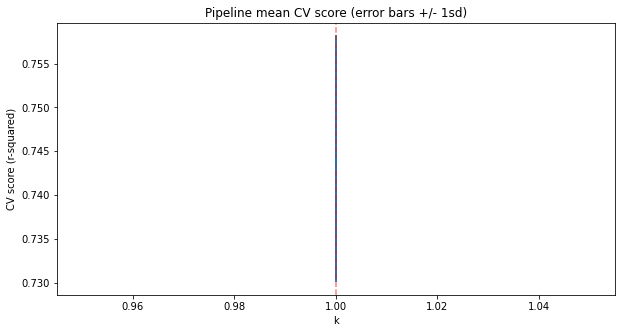

In [358]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model Metrics From RPB Variant

#### R-squared (COD)

In [359]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.73269817, 0.72464451, 0.75870929, 0.75997323, 0.74526363])

In [360]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.744257766856116, 0.013965231204170236)

#### Mean Absolute Error (MAE)

In [361]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [362]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(2.9184920547700894, 0.10585585277044396)

In [363]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

2.9331082941951707

#### Mean Squared Error (MSE)

In [364]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [365]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(17.66861239457461, 0.8188559849946029)

In [366]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

17.89861794048956

#### Root Mean Square Error (RMSE)

In [367]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [368]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(4.20227344627988, 0.09752065045741462)

In [369]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

4.230675825502299

Results for Different Decay-Variants (RMSE) deviation in minutes

Previous 10-day-specific puzzles weighting: (10,9,8,7,6,5,4,3,2,1)
Training: (4.31684221016073, 0.2229381180756284), Test: 4.348894345064849

Previous 10-day-specific puzzles NO decay weighting: (1,1,1,1,1,1,1,1,1,1)
Training: (4.272691291066069, 0.1798200075360626), Test: 4.307939039695358


Previous 20-day-specific puzzles weighting: (20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1)
Training: (4.224302715958222, 0.14223738375467831), Test: 4.25663445521504

Previous 20-day-specific puzzles NO decay weighting: (all 1s)
Training: (4.20227344627988, 0.09752065045741462), Test: 4.230675825502299


Previous 25-day-specific puzzles weighting: (25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1)
Training: (4.206382545199226, 0.1248964276889695), Test: 4.237242987021893

Previous 25-day-specific puzzles NO decay weighting: (all 1s)
Training: (4.199000848753567, 0.10969046940287826), Test: 4.224093779225859 